!pip install census

!pip install us

In [1]:
from census import Census
from us import states
import pandas as pd
import numpy as np
import pylab as pl
import csv
from functools import reduce
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Insert your census api key here below

In [2]:
c = Census("4c26aa6ebbaef54a55d3903212eabbb506ade381")

#### This is the data dictionary

#### 2000 SF3 Variables

#### Creating the buckets for variables that are separeted into bins like income

In [3]:
buckets = [0, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 75000, 100000, 125000, 150000, 200000,1000000]

#### Insert the variables you want to download. The second part is just so it is automated.

In [4]:
variables = ['P0060', 'H0620', 'H0630', 'H0850', 'H0070', 'P0520', 'P0530', 'P0370']

In [5]:
var=[]
for i in variables:
    var.append(i+'01')
    if ((i == 'P0060') | (i == 'H0620') | (i == 'H0070')):
        var.append(i+'02')
    if i == 'H0070':
        var.append(i+'03')

In [6]:
var.append('NAME')
for i in range(2,10):
    var.append('P05200'+str(i))
for i in range(10,18):
    var.append('P0520'+str(i))

In [7]:
var.append('P037015')
var.append('P037032')
var.append('P007004')
var.append('P006005')
var.append('P007010')
var.append('P021013')
var.append('H038009')
var.append('H038014')
var.append('H038015')
var.append('H069001')
var.append('H069007')
var.append('H069008')
var.append('H069009')
var.append('H069010')
var.append('HCT001005')
var.append('HCT001012')
var.append('HCT001018')
var.append('HCT001031')
var.append('HCT001038')
var.append('HCT001044') 
var.append('P032001')
var.append('P032002')
var.append('P032005')
var.append('P032008')
var.append('P032011')

#### Choose the state and insert its code (as a string number)

In [8]:
state = '36'

In [9]:
sql_query='state:{} county:*'.format(state)

In [10]:
dic = c.sf3.get(var, geo = {'for': 'tract:*',
                       'in': sql_query}, year = 2000)

In [11]:
df = pd.DataFrame.from_dict(dic)

In [12]:
df = df.reset_index()

In [13]:
df = df.drop(columns = 'index')

#### Exporting the raw file

In [14]:
df.to_csv('variables_' + state + '.csv', index = None)

#### Calculating the thresholds for each of the counties

In [15]:
county = df.county.unique()

In [16]:
counties = {}
counties = counties.fromkeys(county)

In [17]:
columns = df.columns

In [18]:
for i in range(0,len(columns)-3):
    if i!=21:
        df[columns[i]] = df[columns[i]].astype(float)

In [19]:
for i in county:
    counties[i] = np.median(df[df.county == i].P053001)

In [20]:
df_threshold = pd.DataFrame.from_dict(counties, orient='index')

In [21]:
df_threshold = df_threshold.rename(columns={0:'median'})

In [22]:
#df_typo['vvli_threshold']=0.3*df_typo['median']
df_threshold['vli_threshold'] = 0.5*df_threshold['median']
df_threshold['li_threshold'] = 0.8*df_threshold['median']
df_threshold['mi_threshold'] = 1.2*df_threshold['median']
df_threshold['mhi_threshold'] = 1.5*df_threshold['median']
df_threshold['hi_threshold'] = 2*df_threshold['median']
df_threshold['vhi_threshold'] = 1000000

#### Creating the different typologies based on each county's median income

In [23]:
table = np.zeros((len(county),len(buckets)-1))
for j in range(0, len(counties)):
    col = 1
    for i in range(0, len(buckets)-1):
        if buckets[i+1] < df_threshold.iloc[j, col]:
            table[j, i] = True
        else:
            table[j, i] = (df_threshold.iloc[j, col] - buckets[i]) / (buckets[i+1] - buckets[i])
            col = col+1

In [24]:
values=[]
for i in county:
    with open('variables_'+state+'.csv', 'r') as fi:
        reader = csv.DictReader(fi)
        def creator(reader, c):
            bt = filter(lambda x: x['county'] == c, reader)
            return (list(bt))
        value = creator(reader, i)
    values.append(value)

In [25]:
income_typo = []
for j in range(0, len(county)):
    for i in range(0, len(values[j])):
        typo = []
        summ = 0
        for col in range(0,len(buckets)-1):
            if ((table[j, col] == 1) & (values[j][i][var[9]]!='0')):
                summ = summ + float(values[j][i][var[13+col]])/float(values[j][i][var[9]])
            else:
                if values[j][i][var[9]]!='0':
                    summ = summ + float(values[j][i][var[13+col]])*table[j, col]/float(values[j][i][var[9]])
                    typo.append(summ)
                    summ = float(values[j][i][var[13+col]])*(1-table[j, col])/float(values[j][i][var[9]])
        typo.append(summ)
        income_typo.append(typo)

In [26]:
df_final = pd.DataFrame(income_typo)

In [27]:
df_final = df_final.rename(columns={0:'vli_00', 1:'li_00', 2:'mi_00', 3:'mhi_00', 4:'hi_00', 5:'vhi_00'})

In [28]:
df['col_00'] = df['P037015'] + df['P037032']

In [29]:
df['burden_00'] = df['H069007'] + df['H069008'] + df['H069009'] + df['H069010']

In [30]:
df['commute_med_00'] = df['P032005'] + df['P032008']

In [31]:
df['burden_00'] = df['H069007'] + df['H069008'] + df['H069009'] + df['H069010']

In [32]:
df['hhwchild_00']= df['HCT001005'] + df['HCT001012'] + df['HCT001018'] + df['HCT001031'] + df['HCT001038'] + df['HCT001044']

In [33]:
moe_names = ['per_col_00', 'per_rent_00', 'per_owners_00', 'per_nonwhite_00', 'per_black_00', 'per_asian_00', 
             'per_latino_00', 'per_hhwchild_00',  'per_commute_low_00', 'per_commute_med_00', 'per_commute_high_00',
            'per_burden_00', 'per_foreign_00']

moe_dividend = ['col_00', 'H007003', 'H007002', 'P006002', 'P007004', 'P006005', 'P007010', 'hhwchild_00', 'P032002',
               'commute_med_00', 'P032011', 'burden_00', 'P021013']

moe_divisor = ['P037001', 'H007001', 'H007001', 'P006001', 'P006001', 'P006001', 'P006001', 'H007001', 'P032001', 
               'P032001', 'P032001', 'H069001', 'P006001']

In [34]:
for i in range(0,len(moe_names)):
    if i!=3:
        df_final[moe_names[i]] = df[moe_dividend[i]]/df[moe_divisor[i]]
    else:
        df_final[moe_names[i]] = 1 - df[moe_dividend[i]]/df[moe_divisor[i]]

In [35]:
df = df.rename(columns={'P052001':'hh_00', 'H063001':'mrent_00', 'P053001':'hinc_00', 
                        'H085001':'mhval_00', 'H007001':'hu_00', 'P006001':'pop_00'})

In [36]:
df_final = df_final.join(df[['hh_00', 'mrent_00', 'hinc_00', 'mhval_00', 'hu_00', 'pop_00', 'NAME', 'state', 'county',
                             'tract']])

#### Interpolating the data to fit 2010 census tract boundaries

In [37]:
df_final['GEOid2'] = df_final['state'] + df_final['county'] + df_final['tract']

In [38]:
df_final['GEOid2'] = df_final.GEOid2.apply(lambda x: int(x))

In [39]:
df_crosswalk_00 = pd.read_csv('crosswalk_2000_2010.csv')

In [40]:
df_crosswalk_00['state'] = df_crosswalk_00.trtid00.apply(lambda x: str(x)[:2])

In [41]:
df_crosswalk_00_red = df_crosswalk_00[df_crosswalk_00.state==state]

In [42]:
df_crosswalk_00_red = df_crosswalk_00_red.reset_index().drop(columns=['index'])

In [43]:
id00 = list(df_crosswalk_00_red.trtid00.unique())

In [44]:
id10 = list(df_crosswalk_00_red.trtid10.unique())

#### Droping null values

In [45]:
prev_len = len(df_final)

In [46]:
df_final = df_final.dropna(axis = 0, how = 'any')

In [47]:
final_len = len(df_final)

In [48]:
print('The percentage of information lost is: {}'.format((prev_len-final_len)*100/prev_len))

The percentage of information lost is: 2.6288974933768086


#### Exporting the SF3 1990 final file

In [49]:
df_final['GEOid2'] = df_final['state'] + df_final['county'] + df_final['tract']

In [50]:
df_final['GEOid2'] = df_final.GEOid2.apply(lambda x: str(x))

In [51]:
df_final = df_final.drop(columns='NAME')

In [52]:
df_final.to_csv(state+'_2000_variables.csv', index = None)

#### Interpolating the data to fit 2010 census tract boundaries

In [53]:
df_crosswalk_00 = pd.read_csv('crosswalk_2000_2010.csv')

In [54]:
df_crosswalk_00['state'] = df_crosswalk_00.trtid00.apply(lambda x: str(x)[:2])

In [55]:
df_crosswalk_00_red = df_crosswalk_00[df_crosswalk_00.state==state]

In [56]:
df_crosswalk_00_red = df_crosswalk_00_red.reset_index().drop(columns=['index'])

In [57]:
df_crosswalk_00_red['trtid10'] = df_crosswalk_00_red['trtid10'].apply(lambda x: str(x))
df_crosswalk_00_red['trtid00'] = df_crosswalk_00_red['trtid00'].apply(lambda x: str(x))

In [58]:
id00 = list(df_crosswalk_00_red.trtid00.unique())
id10 = list(df_crosswalk_00_red.trtid10.unique())

#### Cleaning total weight sums that exceeds an stablished threshold

In [59]:
threshold = 0.2

In [72]:
weight_total = 0
for i in id10:
    weight_total = np.sum(df_crosswalk_00_red[df_crosswalk_00_red.trtid10==i].weight)
    if ((weight_total<1-threshold)|(weight_total>1+threshold)):
        id10.remove(i)
        df_crosswalk_00_red = df_crosswalk_00_red[df_crosswalk_00_red.trtid10!=i]
        print(i)

l=[]
for i in range(0,len(df_crosswalk_00_red)):
    l.append(df_crosswalk_00_red['weight'][i]/weight_total[df_crosswalk_00_red.trtid10[i]])

df_crosswalk_00_red['weight'] = l

In [73]:
df_crosswalk_00_red = df_crosswalk_00_red.reset_index().drop(columns='index')

In [74]:
df_final[df_final.GEOid2.isin(id10)].to_csv(state+'_2000_variables_clean.csv', index = None)

In [75]:
tract_id10 = {}
tract_id10 = tract_id10.fromkeys(id10)
for i in range(0, len(df_crosswalk_00_red)):
        if (type(tract_id10[df_crosswalk_00_red['trtid10'][i]])==list):
            tract_id10[df_crosswalk_00_red['trtid10'][i]].append(df_crosswalk_00_red['trtid00'][i])
        if (type(tract_id10[df_crosswalk_00_red['trtid10'][i]])!=list):
            tract_id10[df_crosswalk_00_red['trtid10'][i]] = [df_crosswalk_00_red['trtid00'][i]]

In [76]:
weight_dic = {}
weight_dic = weight_dic.fromkeys(id10)
for i in id10:
    weight_dic[i] = weight_dic.fromkeys(tract_id10[i])

In [77]:
geoid = df_final[df_final.GEOid2.isin(id10)].GEOid2.unique()

In [78]:
for i in range(0,len(df_crosswalk_00_red)):
    try:
        if ((df_crosswalk_00_red['trtid00'][i] in geoid) & (df_crosswalk_00_red['weight'][i]!=0)):
            weight_dic[df_crosswalk_00_red['trtid10'][i]][df_crosswalk_00_red['trtid00'][i]] = df_crosswalk_00_red['weight'][i]
        elif ((len(weight_dic[df_crosswalk_00_red['trtid10'][i]])==1)|(df_crosswalk_00_red['weight'][i]!=0)):
            weight_dic.pop(df_crosswalk_00_red['trtid10'][i])
        else:
            weight_dic[df_crosswalk_00_red['trtid10'][i]].pop(df_crosswalk_00_red['trtid00'][i])
    except:
        pass

In [79]:
def cross(dictionary, reader, key, weight):
    with open(state+'_2000_variables_clean.csv', 'r') as fi:
        reader = csv.DictReader(fi)
        bt = list(filter(lambda x: x['GEOid2'] == key, reader))
        nt = np.fromiter(bt[0].values(), dtype = float)[:-4]*weight
    return (nt)
arr = map(lambda j: reduce((lambda x,y: x+y),(map(lambda k: cross(weight_dic[j], 
                                              reader, k, weight_dic[j][k]), 
                                             list(map(lambda x: x, weight_dic[j]))))), 
                                             list(map(lambda j: j, weight_dic)))

In [80]:
df_final_crosswalk = pd.DataFrame(list(arr), columns = df_final.iloc[:,:-4].columns)

In [81]:
df_final_crosswalk['GEOid2'] = list(map(lambda j: j, weight_dic))

In [82]:
print('The percentage of information lost is: {}'.format((len(df_final)-len(df_final_crosswalk))*100/len(df_final)))

The percentage of information lost is: 17.203850983675178


#### Exporting the final file

In [83]:
df_final_crosswalk.to_csv(state+'_2000_variables_crosswalk.csv', index = None)

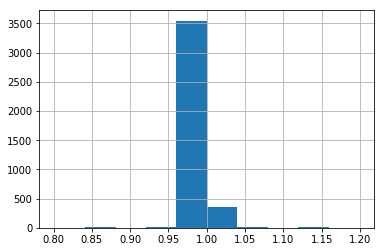

In [84]:
df_final_crosswalk.iloc[:,:6].sum(axis=1).hist()